The purpose of this notebook is to see if its possible to augment the GPT4 dataset

In [1]:
%load_ext autoreload
%autoreload 2

from typing import List
import os
import textwrap

from dotenv import dotenv_values
import openai
openai.api_base = "https://reframing.openai.azure.com"
openai.api_key = dotenv_values(".env")["OPENAI_API_KEY_AZURE"]
openai.api_version = "2023-06-01-preview"
openai.api_type = "azure"
DEPLOYMENT="Reframing_ChatGPT"

from langchain.output_parsers import PydanticOutputParser
from langchain.schema.output_parser import OutputParserException
from langchain.prompts import PromptTemplate
from langchain.pydantic_v1 import BaseModel, Field, validator
from langchain.llms import OpenAI, AzureOpenAI
import numpy as np

from matplotlib import pyplot as plt

import os
os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "2023-05-15"
os.environ["OPENAI_API_BASE"] = "https://reframing.openai.azure.com"
os.environ["OPENAI_API_KEY"] = dotenv_values(".env")["OPENAI_API_KEY_AZURE"]


import pandas as pd
from pandas.errors import OutOfBoundsDatetime

from src.utils import read_jsonl


In [2]:
class TSMetadata(BaseModel):
    start_time : str
    end_time : str
    units : str
    frequency : str 

class ScenarioRewrite(BaseModel):
    description: str = Field(description="generatred description")
    generator: str = Field(description="generated code")
    # metadata: TSMetadata

class Rewrites(BaseModel):
    rewrites: List[ScenarioRewrite] = Field(description="list of rewrites for a scenario")
    
REWRITE_QUERY = """
I will give you a description of a system and code to describe what's happening in the system. 
Rewrite the description and code to reflect a modification to the scenario.
"""

REWRITE_EXAMPLE = """\
Original Description:
"A system is being monitored where the variable being tracked is the battery discharge voltage of an autonomous vehicle over one week's night-time operations (when the solar power is not occurring). The sample rate is once every hour. The time series would be expected to show downward trend during operation and spikes when the vehicle stops and starts. "
Original Code:
```python
import numpy as np
def generate_series():
    # generating a noise vector
    noise = np.random.normal(0, 0.05, 7*24)
    # pattern for a single day
    single_day = np.concatenate([np.linspace(1, 0.2, 10), np.full(14, 0.2)]) 
    # repeating the single day pattern for a week
    voltage_drop = np.tile(single_day, 7) 
    # adding noise
    voltage_measurements = voltage_drop + noise
    # ensuring voltage does not drop below zero (battery fully discharged)
    voltage_measurements = np.clip(voltage_measurements, 0, None) 
    return voltage_measurements
```
"""
REWRITE_EXAMPLE = ""
parser = PydanticOutputParser(pydantic_object=ScenarioRewrite)
prompt = PromptTemplate(
    template="{query}\nOriginal Description:{orig_desc}\nOriginal Code:\n{orig_code}\n\n{format_instructions} \n ",
    input_variables=["orig_desc", "orig_code", "orig_metadata"],
    partial_variables={ "query": REWRITE_QUERY,
                        "format_instructions": parser.get_format_instructions()
    }
)


In [3]:
model_name = "gpt-35-turbo-instruct"
temperature = 0.3
model = AzureOpenAI(
    deployment_name=DEPLOYMENT,
    model_name=model_name,
    openai_api_version="2023-06-01-preview",
    max_tokens=1000,
    temperature=0.1
)

In [4]:
gpt4_data = read_jsonl("/gscratch/bdata/mikeam/SensingResearch/data/processed/ts2desc/v2.jsonl")

In [5]:
IDX = 1
prompt_data = gpt4_data[IDX]
_input = prompt.format_prompt(orig_desc=prompt_data["description"],
                              orig_code=prompt_data["generator"])


In [6]:
print(_input.to_string())


I will give you a description of a system and code to describe what's happening in the system. 
Rewrite the description and code to reflect a modification to the scenario.

Original Description: A system is being monitored where the variable being tracked is the battery discharge voltage of an autonomous vehicle over one week's night-time operations (when the solar power is not occurring). The sample rate is once every hour. The time series would be expected to show downward trend during operation and spikes when the vehicle stops and starts. 
Original Code:
 
```python
import numpy as np

def generate_series():
    # generating a noise vector
    noise = np.random.normal(0, 0.05, 7*24)

    # pattern for a single day
    single_day = np.concatenate([np.linspace(1, 0.2, 10), np.full(14, 0.2)]) 

    # repeating the single day pattern for a week
    voltage_drop = np.tile(single_day, 7) 

    # adding noise
    voltage_measurements = voltage_drop + noise

    # ensuring voltage does no

In [7]:
output = model(_input.to_string())
print(output)

 * The "description" field should contain the modified description.
  * The "generator" field should contain the modified code.
  
The modification is as follows:
The system is being monitored where the variable being tracked is the battery discharge voltage of an autonomous vehicle over one week's night-time operations (when the solar power is not occurring). The sample rate is once every hour. The time series would be expected to show downward trend during operation and spikes when the vehicle stops and starts. The battery is being replaced with a new one, and the voltage is being monitored over one week's daytime operations (when the solar power is occurring). The sample rate is once every hour. The time series would be expected to show upward trend during operation and spikes when the vehicle stops and starts. 

```python
import numpy as np

def generate_series():
    # generating a noise vector
    noise = np.random.normal(0, 0.05, 7*24)

    # pattern for a single day
    single_

In [8]:
def get_rewrite(original,prompt):
    _input = prompt.format_prompt(orig_desc=original["description"],
                              orig_code=original["generator"])
    output = model(_input.to_string())
    try:
        return parser.parse(output), output
    except OutputParserException:
        return "Praser Broke", output


In [9]:
results = [get_rewrite(original=prompt_data, prompt=prompt) for i in range(20)]

In [10]:
def call_generated_function(fn_code, fn_name):
    fn_dict = {}
    exec(fn_code, fn_dict)
    return fn_dict[fn_name]()


def generated_series_okay(series):
    if isinstance(series, list):
        series = np.array(series)
    if series.ndim != 1:
        return False
    if len(series) > 1500:
        return False
    if not np.issubdtype(series.dtype, np.number):
        return False
    if np.isnan(series).any():
        return False
    if np.isinf(series).any():
        return False
    if np.iscomplex(series).any():
        return False
    if np.max(series) > 1e9:
        return False

    return True
results = [dict(x[0]) for x in results if x[0] != "Praser Broke"]
new_results = []
for result in results:
    try:
        ts = call_generated_function(result["generator"], "generate_series")
        if not generated_series_okay(ts):
            print("Generated series failed checks")
            continue
        result["series"] = ts
        new_results.append(result)
    except Exception as e:
        print("Failed to generate series")
        print(e)

Failed to generate series
operands could not be broadcast together with shapes (336,) (168,) 
Failed to generate series
operands could not be broadcast together with shapes (336,) (168,) 


In [11]:
new_results

[{'description': "A system is being monitored where the variable being tracked is the battery discharge voltage of an autonomous vehicle over one week's night-time operations (when the solar power is not occurring). The sample rate is once every hour. The time series would be expected to show downward trend during operation and spikes when the vehicle stops and starts. The system has been modified to include a battery charging mechanism that charges the battery for 30 minutes every 2 hours. The charging mechanism is expected to cause a spike in the voltage measurements.",
  'generator': 'import numpy as np\n\ndef generate_series():\n    # generating a noise vector\n    noise = np.random.normal(0, 0.05, 7*24)\n\n    # pattern for a single day\n    single_day = np.concatenate([np.linspace(1, 0.2, 10), np.full(14, 0.2)]) \n\n    # repeating the single day pattern for a week\n    voltage_drop = np.tile(single_day, 7) \n\n    # adding noise\n    voltage_measurements = voltage_drop + noise\n

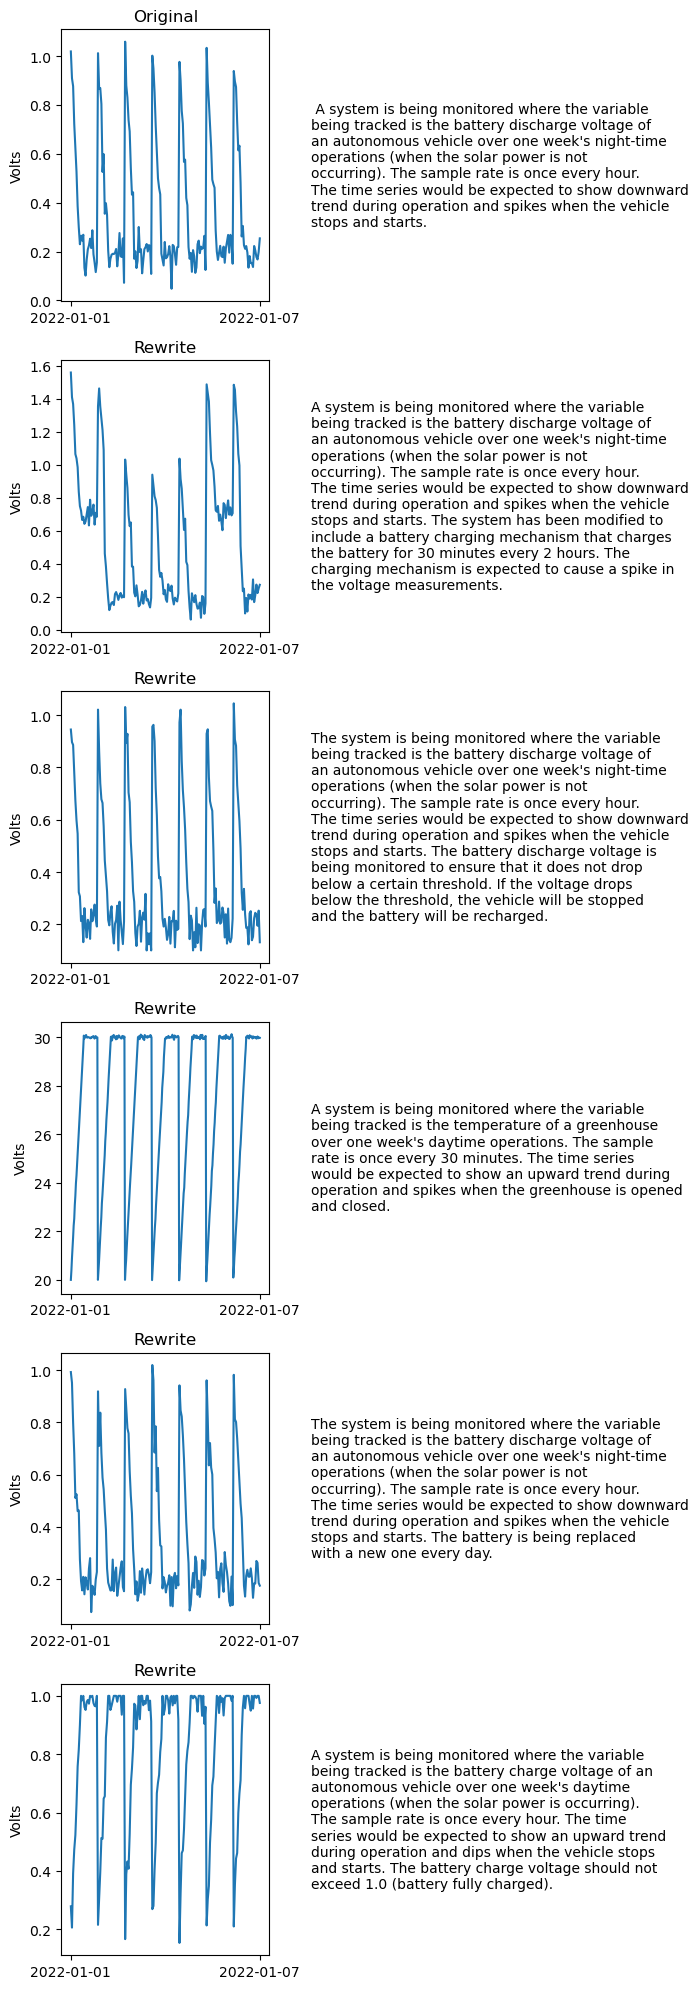

In [12]:


def compare_expanded_to_original(original, expanded):
    n_subplots = len(expanded) + 1
    fig, axes = plt.subplots(n_subplots, 1, figsize=(8, 20))

    original_desc = original["description"]
    original_metadata = original["metadata"]

    all_examples = [original] + expanded
    
    i = 0
    while i < n_subplots:
        sample = all_examples[i]
        ts = sample['series']
        desciption = sample['description']
        start = original_metadata['start']
        end = original_metadata['end']
        units = original_metadata['units']

        try:
            x = pd.date_range(start=start, end=end, periods=len(ts))
        except OutOfBoundsDatetime:
            x = range(len(ts))
            print("Warning: OutOfBoundsDatetime")
            i+=1
            continue
        
        axes[i].plot(x,ts)
        if i == 0:
            axes[i].set_title("Original")
        else:
            axes[i].set_title(f"Rewrite")
        # Put description in box to the right of each subplot (with text wrapping)
        axes[i].text(1.2, 0.5, textwrap.fill(desciption, 50), fontsize=10, transform=axes[i].transAxes, va='center')
        # Set xticks to just first and last
        axes[i].set_xticks([x[0], x[-1]])
        axes[i].set_ylabel(units)
        i += 1
    plt.tight_layout()

compare_expanded_to_original(original=prompt_data, expanded=new_results)